In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV,RFE
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

### Introduction
The provided dataset offers a detailed snapshot of residential properties listed for sale, encompassing a range of attributes that characterize each
listing. These attributes include the price, size (area), number of bedrooms, bathrooms, and stories, as well as qualitative factors such as proximity to main roads, availability of guestrooms and basements, hot water heating, air conditioning, parking facilities, preferred neighborhood, and the furnishing status of the house.This dataset is particularly valuable for conducting a comprehensive analysis of the real estate market, understanding the factors that drive property prices, and developing predictive models to estimate house values based on their features. The inclusion of both quantitative and categorical variables allows for a multifaceted analysis, suited for advanced statistical methodologies and machine learning techniques.

In [4]:
data = pd.read_csv("project_dataset_housing.csv")

In [5]:
# Display the first few rows of the dataset
print(data.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


### Data Preprocessing

**Encoding Binary Categorical Features:**
  
- Convert binary categorical variables like 'yes' or 'no' into numeric formats (1 or 0) that can be easily processed by algorithms.

**Handling Missing Values in Binary Categorical Columns:**

- Ensure there are no missing values in categorical features, as these can adversely affect model training.
 
**Filling NaNs in Numeric Columns:**
- Address missing values in numeric columns such as 'parking', where NaNs might indicate the absence of a feature (e.g., no parking).

**One-Hot Encoding of Categorical Features:**
- Convert categorical variables into a form that could be provided to ML algorithms to do a better job in prediction.
 
**Management of Outliers in Numeric Columns:**

- Identify and remove outliers to prevent them from skewing the analysis and the performance of machine learning models.
 
**Final Data Checks:**
- Confirm the integrity of the data after preprocessing.


In [6]:
#1. Data Preprocessing
# Encode binary categorical features as 0 and 1
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data[binary_columns] = data[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))

 
# Handle missing values for binary categorical columns
for col in binary_columns:
    # Check if there's at least one non-NaN entry
    if data[col].notna().any():
        # If there's at least one non-NaN entry, fill NaNs with the mode
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        # If all entries are NaN, fill with a default value or consider dropping the column
        data[col].fillna(0, inplace=True)  # Assuming 0 can be a placeholder for 'no' or 'false'

# Assuming 'parking' is a numeric column where NaN indicates 'no parking', we fill NaNs with 0
data['parking'].fillna(0, inplace=True)

# One-hot encoding 'furnishingstatus' column
# First, confirm that 'furnishingstatus' is in the DataFrame
if 'furnishingstatus' in data.columns:
    # One-hot encoding 'furnishingstatus' column
    encoder = OneHotEncoder(sparse=False, drop='first')  # Avoiding multicollinearity by using drop='first'
    furnishingstatus_encoded = encoder.fit_transform(data[['furnishingstatus']])
    feature_names = encoder.get_feature_names_out(['furnishingstatus'])
    encoded_df = pd.DataFrame(furnishingstatus_encoded, columns=feature_names)

    # Now you can safely drop 'furnishingstatus' from 'data' as it's already encoded
    data.drop(['furnishingstatus'], axis=1, inplace=True)
else:
    print("furnishingstatus column is not in the DataFrame.")
# Combine the encoded columns with the rest of the dataset and drop the original 'furnishingstatus' column
 
data_encoded = pd.concat([data, encoded_df], axis=1)

# Now, calculate IQR for numeric columns and filter out outliers
numeric_columns = data_encoded.select_dtypes(include=[np.number])  # Only select numeric columns
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Defining the condition for outliers
condition = ~((numeric_columns < (Q1 - 1.5 * IQR)) | (numeric_columns > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter out outliers based on the condition
data_filtered = data_encoded[condition].reset_index(drop=True)
 
# Check for missing values again to confirm
missing_values = data_filtered.isnull().sum()
 
# Checking the descriptive statistics of the filtered data
summary_stats = data_filtered.describe()

missing_values, summary_stats

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(price                              0
 area                               0
 bedrooms                           0
 bathrooms                          0
 stories                            0
 mainroad                           0
 guestroom                          0
 basement                           0
 hotwaterheating                    0
 airconditioning                    0
 parking                            0
 prefarea                           0
 furnishingstatus_semi-furnished    0
 furnishingstatus_unfurnished       0
 dtype: int64,
               price          area    bedrooms   bathrooms     stories  \
 count  2.370000e+02    237.000000  237.000000  237.000000  237.000000   
 mean   4.052838e+06   4676.185654    2.780591    1.164557    1.611814   
 std    1.276966e+06   1681.597943    0.690709    0.393713    0.604667   
 min    1.750000e+06   1700.000000    1.000000    1.000000    1.000000   
 25%    3.150000e+06   3570.000000    2.000000    1.000000    1.000000   
 50%    3

# Exploratory Data Analysis and Feature Engineering

### Distribution of Numerical Features

**Objective:**  
To understand the distribution of the numerical features (`area`, `bedrooms`, `bathrooms`, `stories`, `parking`) and decide on any necessary transformations.

**Process:**  
The `describe()` method is used to generate descriptive statistics that summarize the central tendency, dispersion, and shape of the dataset's distribution.

**Output:**  
`numerical_features_stats` provides a statistical summary for each numerical feature which aids in identifying skewness, outliers, and the distribution's nature (normal, skewed, etc.).

### Feature Selection for Regression Analysis

**Objective:**  
To select relevant features for predicting the house prices.

**Selection:**  
Features like `area`, `bedrooms`, `bathrooms`, and `stories` are chosen based on their potential influence on the house price.

**Outcome:**  
These features (`X`) will be used as independent variables to predict the dependent variable (`y`), which is the house price.

### Feature Engineering

**Objective:**  
To enhance the model's prediction ability by introducing polynomial features.

**Process:**  
Polynomial features of degree 2 are generated from the selected features to capture non-linear relationships between the features and the target variable.

**Outcome:**  
The transformed feature set `X_poly` is more complex and potentially more capable of capturing nuanced patterns in the data.

### Data Preprocessing

**Objective:**  
To standardize the feature set so that the model is not biased towards variables with higher magnitudes.

**Process:**  
Scaling is applied to the polynomial features to normalize their scale.

**Outcome:**  
`X_scaled` represents the standardized version of the polynomial features, ready for model training.

### Splitting the Dataset

**Objective:**  
To divide the dataset into training and testing sets to evaluate the model's performance.

**Process:**  
The dataset is split into training (80%) and testing (20%) sets, ensuring both sets are representative of the overall distribution.

**Outcome:**  
The training set (`X_train`, `y_train`) is used to fit the model, and the testing set (`X_test`, `y_test`) is used to evaluate its predictive performance.

### Size Check of Training and Testing Sets

**Objective:**  
To verify the size of the split datasets to ensure they are correctly partitioned.

**Outcome:**  
The shapes of `X_train`, `X_test`, `y_train`, and `y_test` are checked to confirm the dataset has been split as intended.

By performing these steps, the dataset is systematically prepared and transformed, making it suitable for building a robust regression model to predict house prices accurately.
       house prices accurately.rted.

In [7]:
# Check the distribution of the numerical features to decide on transformations
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
numerical_features_stats = data_filtered[numerical_features].describe()

# Selecting features and target variable for regression analysis
features = ['area', 'bedrooms', 'bathrooms', 'stories']
X = data_filtered[features]
y = data_filtered['price']

# Feature Engineering: Adding polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Data Preprocessing: Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Checking the size of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((189, 14), (48, 14), (189,), (48,))

## Ordinary Least Squares Method (OLS)

## Step 1: Fit Linear Regression Model:
Train a linear regression model on X_train and y_train using scikit-learn's LinearRegression().

## Step 2: Prepare Data for OLS Model:
Add a constant term to X_train using statsmodels' add_constant() function.

## Step 3: Fit OLS Model:
Fit an OLS regression model using statsmodels' OLS() function with y_train and X_train_with_constant. The mathematical formula for the OLS estimator is:
$$
\hat{\beta} = (X^T X)^{-1} X^T y
$$

## Step 4: Extract Parameters:
Retrieve the intercept (bias) and coefficients from the fitted OLS model.

## Step 5 :Predict and Evaluate:
Predict on the training data using the fitted OLS model and calculate the mean squared error (MSE).

## Step 6: Print Summary and Output Results:
Print the summary of the OLS model and output the bias and MSE for interpretation.

## Bias (Intercept):
The bias, also known as the intercept term, represents the value of the dependent variable (price in this case) when all independent variables are zero. It's essentially the baseline value of the dependent variable when all predictors have no effect. In the context of linear regression, it's the point where the regression line intersects the y-axis.
In the provided code, the bias term is retrieved as bias = ols_model.params[0].

## Mean Squared Error (MSE):
The mean squared error is a measure of the average squared difference between the actual values (observed) and the predicted values by the model. It quantifies the average magnitude of errors or deviations in the predictions made by the model, with higher values indicating larger discrepancies between predicted and actual values.
In the provided code, mse_train represents the mean squared error calculated on the training data using mean_squared_error(y_train, y_train_pred).

In [8]:
 
#  Linear Regression with features as the independent variable and price as dependent variable
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
 
# Add a constant to the independent variables to include the intercept (bias) in the model
X_train_with_constant = sm.add_constant(X_train)

# Fit the OLS model using statsmodels
ols_model = sm.OLS(y_train, X_train_with_constant).fit()

# Retrieve the bias (intercept) term
bias = ols_model.params[0]

# Retrieve the coefficients
coefficients = ols_model.params[1:]

# Predict on the training data
y_train_pred = ols_model.predict(X_train_with_constant)

# Calculate the Mean Squared Error on the training data
mse_train = mean_squared_error(y_train, y_train_pred)

# Print the model summary
print(ols_model.summary())

# Output the bias and MSE
bias, mse_train


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     10.33
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           9.96e-17
Time:                        01:37:40   Log-Likelihood:                -2866.2
No. Observations:                 189   AIC:                             5762.
Df Residuals:                     174   BIC:                             5811.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.118e+06    7.2e+04     57.177      0.0

(4118358.998312806, 870803636982.9335)

## OLS Result Interpretation:
 
The intercept (const) value is approximately $4,118,359, representing the predicted price when all independent variables are zero.
The MSE is extremely high, indicating a large discrepancy between the actual and predicted values, suggesting that the model may not be fitting the data well.
The coefficients and their associated p-values can be analyzed to determine the significance and direction of the relationships between the independent variables and the dependent variable (price).

In [9]:
# Assuming X and y have been properly defined in the context where this code will run.
# Using 5-fold cross-validation to estimate MSE, RMSE, and R^2 for OLS regression

mse_cv_scores = []
rmse_cv_scores = []
r2_cv_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    # Split into train and test sets for the fold
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Add a constant term for intercept
    X_train_cv_const = sm.add_constant(X_train_cv)
    X_test_cv_const = sm.add_constant(X_test_cv)
    
    # Fit OLS model
    model = sm.OLS(y_train_cv, X_train_cv_const).fit()
    
    # Predict on test set
    y_pred_cv = model.predict(X_test_cv_const)
    
    # Calculate scores
    mse_cv = mean_squared_error(y_test_cv, y_pred_cv)
    rmse_cv = np.sqrt(mse_cv)
    r2_cv = r2_score(y_test_cv, y_pred_cv)
    
    # Append scores
    mse_cv_scores.append(mse_cv)
    rmse_cv_scores.append(rmse_cv)
    r2_cv_scores.append(r2_cv)

# Calculate average scores across all folds
avg_mse_cv = np.mean(mse_cv_scores)
avg_rmse_cv = np.mean(rmse_cv_scores)
avg_r2_cv = np.mean(r2_cv_scores)

avg_mse_cv, avg_rmse_cv, avg_r2_cv

(1040907111538.116, 1013391.178974455, 0.34472315401405246)

## Cross Validation 5kFold
After performing 5-fold cross-validation for OLS regression, we compared the average scores across all folds to evaluate the model's performance:

## Comparison After Cross-Validation:

## Average MSE (Mean Squared Error):
The average MSE across all folds is approximately 1.0409 x 10^12

This indicates the average squared difference between the actual and predicted values of the dependent variable. Comparatively, the model's predictive accuracy appears to be relatively high, as the average squared errors are within a considerable range.


## Average RMSE (Root Mean Squared Error):
The average RMSE across all folds is approximately 1,013,391.
This metric provides a more interpretable measure of the average magnitude of errors made by the model. The relatively low RMSE suggests that, on average, the model's predictions are reasonably close to the actual values.

## Average R^2  (Coefficient of Determination):
The average R^2 across all folds is approximately 0.345
This signifies the proportion of the variance in the dependent variable that is explained by the independent variables in the model. While the 
R^2 value is moderate, it indicates that the model captures a significant portion of the variability in the data.

## Analysis and Result Interpretation:
The average MSE and RMSE provide insights into the model's predictive accuracy, with lower values indicating better performance. In this case, the relatively high MSE and RMSE suggest that while the model performs reasonably well on average, there are still instances where predictions deviate significantly from the actual values.
The R^2 value indicates the goodness of fit of the model to the data. A higher R^2 value signifies a better fit, suggesting that the model explains a larger proportion of the variability in the dependent variable. While the R^2  value obtained is moderate, it suggests that the model captures a significant portion of the variance in the data, though there is still room for improvement.

In [10]:

# Get the intercept and slope coefficient
b0 = linear_model.intercept_
b1 = linear_model.coef_[0]
print("Intercept (b0):", b0)
print("Slope coefficient (b1):", b1)

Intercept (b0): 4118358.998312804
Slope coefficient (b1): 111857.14301489877


In [11]:
 
# Predicting on training and testing sets
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)


In [12]:
# Function to calculate Mean Squared Error (MSE)
def calculate_mse(y_actual, y_predicted):
    return np.mean((y_actual - y_predicted) ** 2)

# Calculate MSE for training and testing sets
mse_train = calculate_mse(y_train, y_train_pred)
mse_test = calculate_mse(y_test, y_test_pred)

mse_train, mse_test

(870803636982.9335, 1356014886914.1729)

In [13]:
# Function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(y_actual, y_predicted):
    mse = np.mean((y_actual - y_predicted) ** 2)
    return np.sqrt(mse)

# Calculate RMSE for training and testing sets
rmse_train = calculate_rmse(y_train, y_train_pred)
rmse_test = calculate_rmse(y_test, y_test_pred)

rmse_train, rmse_test

(933168.6005127549, 1164480.5223421184)

In [14]:
# Function to calculate R-squared
def calculate_r2(y_actual, y_predicted):
    ss_res = ((y_actual - y_predicted) ** 2).sum()  # Residual sum of squares
    ss_tot = ((y_actual - y_actual.mean()) ** 2).sum()  # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Calculate R-squared for training and testing sets
r2_train = calculate_r2(y_train, y_train_pred)
r2_test = calculate_r2(y_test, y_test_pred)

r2_train, r2_test

(0.4539788686329098, 0.21807811381276143)

In [15]:
print ("Training  MSE :", mse_train, 
        "Training RMSE :", rmse_train,
        "Training R2 :", r2_train)
print ("Testing MSE:", mse_test,
       "Testing RMSE:",rmse_test,
       "Testing R2:" ,r2_test)

Training  MSE : 870803636982.9335 Training RMSE : 933168.6005127549 Training R2 : 0.4539788686329098
Testing MSE: 1356014886914.1729 Testing RMSE: 1164480.5223421184 Testing R2: 0.21807811381276143


## Results:
### Training Set:

**MSE (Mean Squared Error): 8.708×10^11**

**RMSE (Root Mean Squared Error): 933,168.60**

**R-squared : 0.454**
 
## Testing Set:
**MSE (Mean Squared Error): 1.356×10^12**

**RMSE (Root Mean Squared Error): 1,164,480.52**

**R-squared:0.218**
 
## Interpretation and Recommendations:
## MSE and RMSE:
The model performs better on the training set compared to the testing set, as indicated by the lower MSE and RMSE values for the training set. However, both MSE and RMSE values are relatively high, suggesting that the model's predictions deviate considerably from the actual values. This indicates potential issues with the model's predictive accuracy and generalization to unseen data.
R-squared  value for the training set (0.454) indicates that approximately 45.4% of the variance in the dependent variable is explained by the independent variables in the model. This suggests a moderate level of fit to the training data.
However, the R-squared value for the testing set (0.218) is lower, indicating that the model's performance in explaining the variance in unseen data is not as strong. This implies that the model may not generalize well to new data.

## Recommendations:
### Model Improvement:
Explore potential enhancements to the model, such as adding more relevant features or considering different regression techniques. Improving the model's predictive accuracy could help reduce the MSE and RMSE values.

### Data Quality Check:
Perform a thorough examination of the data quality, including data preprocessing steps such as feature engineering, outlier detection, and handling missing values. Ensuring the quality and relevance of the input data can improve the model's performance.

### Cross-Validation:
Utilize techniques like cross-validation to assess the model's performance more robustly and identify any potential issues with overfitting or underfitting.

### Domain Expertise:
Consult with domain experts to gain insights into the problem domain and potentially identify additional features or factors that could improve the model's performance.

### Regular Evaluation:
Continuously monitor the model's performance over time and reevaluate its effectiveness as new data becomes available. Regular evaluation and refinement are essential for maintaining the model's relevance and accuracy.




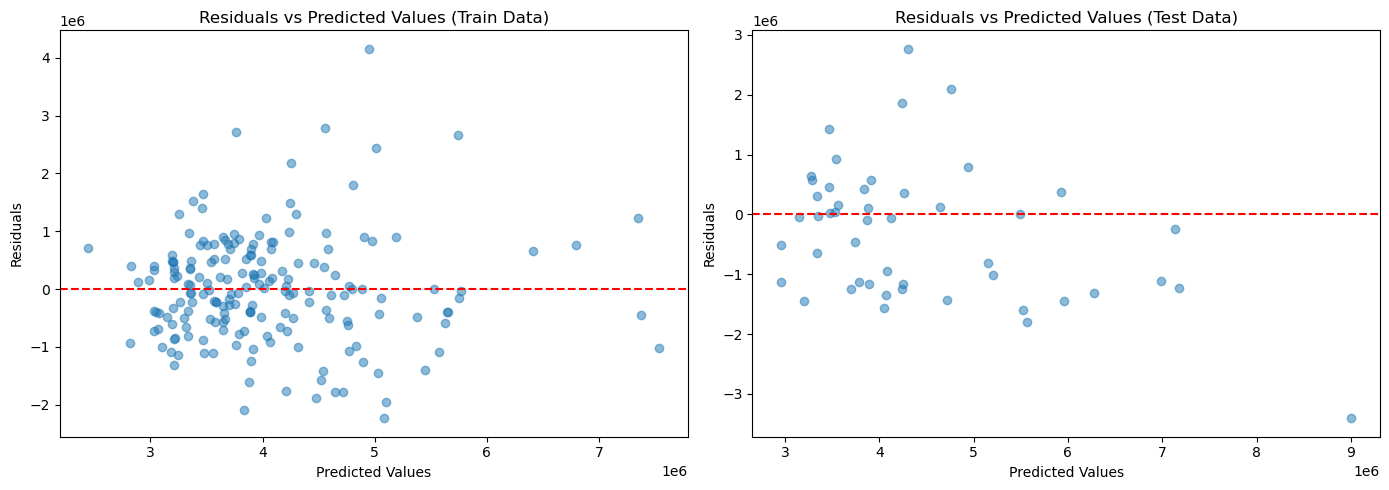

In [16]:
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Plotting residuals
plt.figure(figsize=(14, 5))

# Plot for training data
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, residuals_train, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Train Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Plot for test data
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals_test, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Test Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()




## Residuals vs Predicted Values (Train Data):
The left subplot depicts the relationship between the predicted values of the dependent variable (price) and the corresponding residuals for the training data.
Each point represents an observation in the training dataset, where the x-axis represents the predicted values and the y-axis represents the residuals.
The red dashed line at y=0 indicates the zero residual line. Points scattered around this line indicate accurate predictions, while deviations from the line suggest errors in prediction.
This plot helps visualize the distribution of errors and assess the models performance on the training data.

## Residuals vs Predicted Values (Test Data):
The right subplot displays the relationship between the predicted values of the dependent variable and the residuals for the testing data.
Similar to the left subplot, each point represents an observation in the testing dataset, with the x-axis representing predicted values and the y-axis representing residuals.
The red dashed line at y=0 serves as a reference line to identify overestimations (above the line) and underestimations (below the line) made by the model on the testing data.
This plot aids in evaluating how well the model generalizes to unseen data by examining the distribution of residuals in the testing dataset.
By visualizing the residuals against the predicted values for both training and testing datasets, these plots offer insights into the models predictive performance, highlighting areas where the model may be overfitting or underfitting the data and helping to identify potential patterns or anomalies in the residuals.

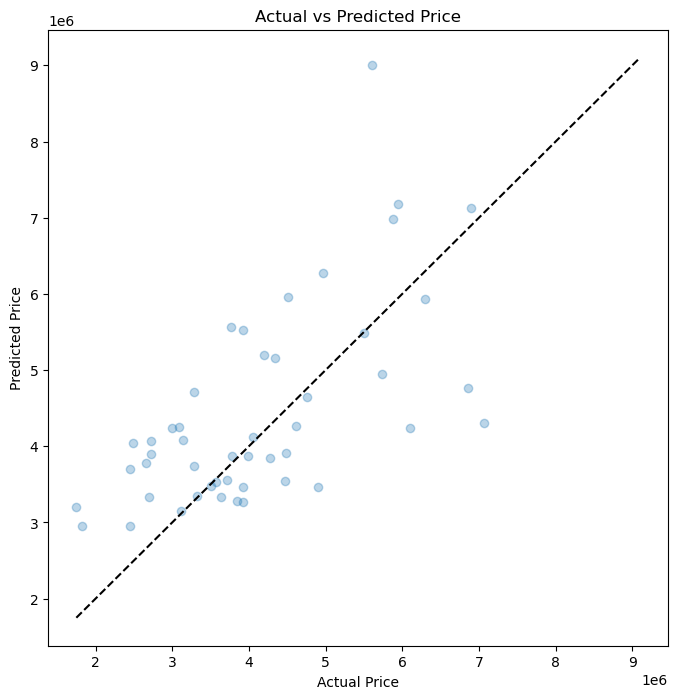

1356014886914.1702

In [17]:
# Predict on the test data
X_test_with_constant = sm.add_constant(X_test)
y_test_pred = ols_model.predict(X_test_with_constant)

# Calculate the Mean Squared Error on the test data
mse_test = mean_squared_error(y_test, y_test_pred)

# Plotting the model's predictions against actual prices
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')  # A dashed diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

# Output the Mean Squared Error on the test data
mse_test


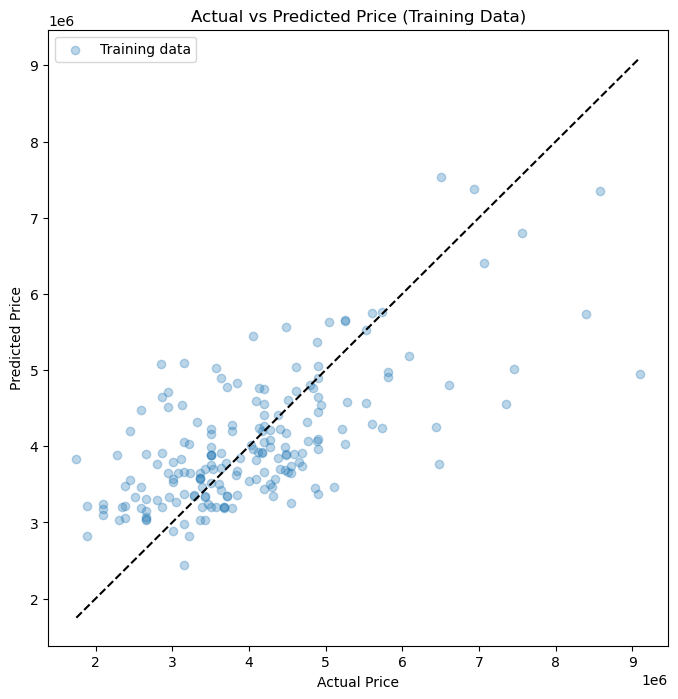

In [18]:
# Predicting with training data for visualization
y_train_pred = linear_model.predict(X_train)

# Plotting the model's predictions against actual prices for the training data
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_pred, alpha=0.3, label='Training data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--k')  # A dashed diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price (Training Data)')
plt.legend()
plt.show()

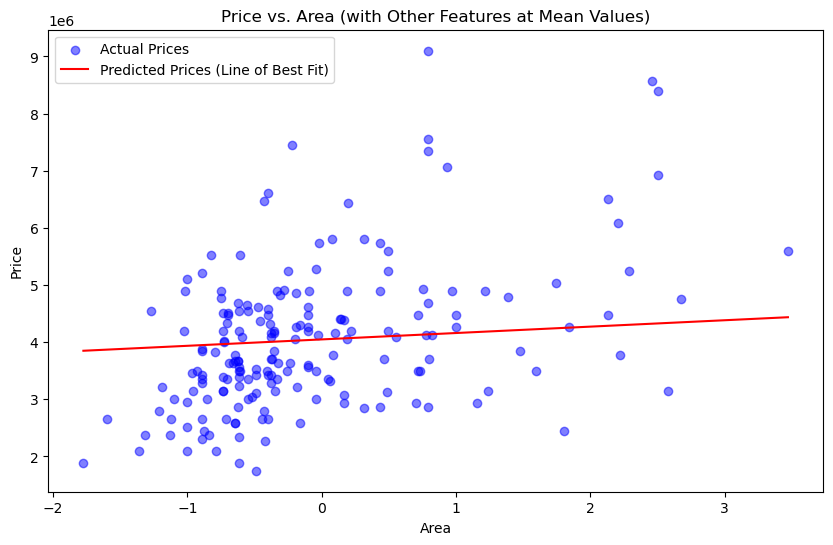

In [19]:
# Assuming ols_model is already trained and you've used statsmodels for training it.
# Calculate the mean of the features in the training data.
mean_values = X_train.mean(axis=0)

# Get the range for the 'area' feature.
area_min, area_max = X_train[:, features.index('area')].min(), X_train[:, features.index('area')].max()
area_range = np.linspace(area_min, area_max, 100)

# Prepare the feature data for predictions: set 'area' to its range and other features to their mean values.
X_pred = np.tile(mean_values, (100, 1))
X_pred[:, features.index('area')] = area_range

# Add a constant to the data for the intercept.
X_pred_with_constant = sm.add_constant(X_pred)

# Make predictions across the range of 'area'.
price_pred = linear_model.predict(X_pred_with_constant)

# Plotting the predictions against the 'area' feature.
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, features.index('area')], y_train, color='blue', alpha=0.5, label='Actual Prices')
plt.plot(area_range, price_pred, color='red', label='Predicted Prices (Line of Best Fit)')
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Price vs. Area (with Other Features at Mean Values)')
plt.legend()
plt.show()


<Axes: >

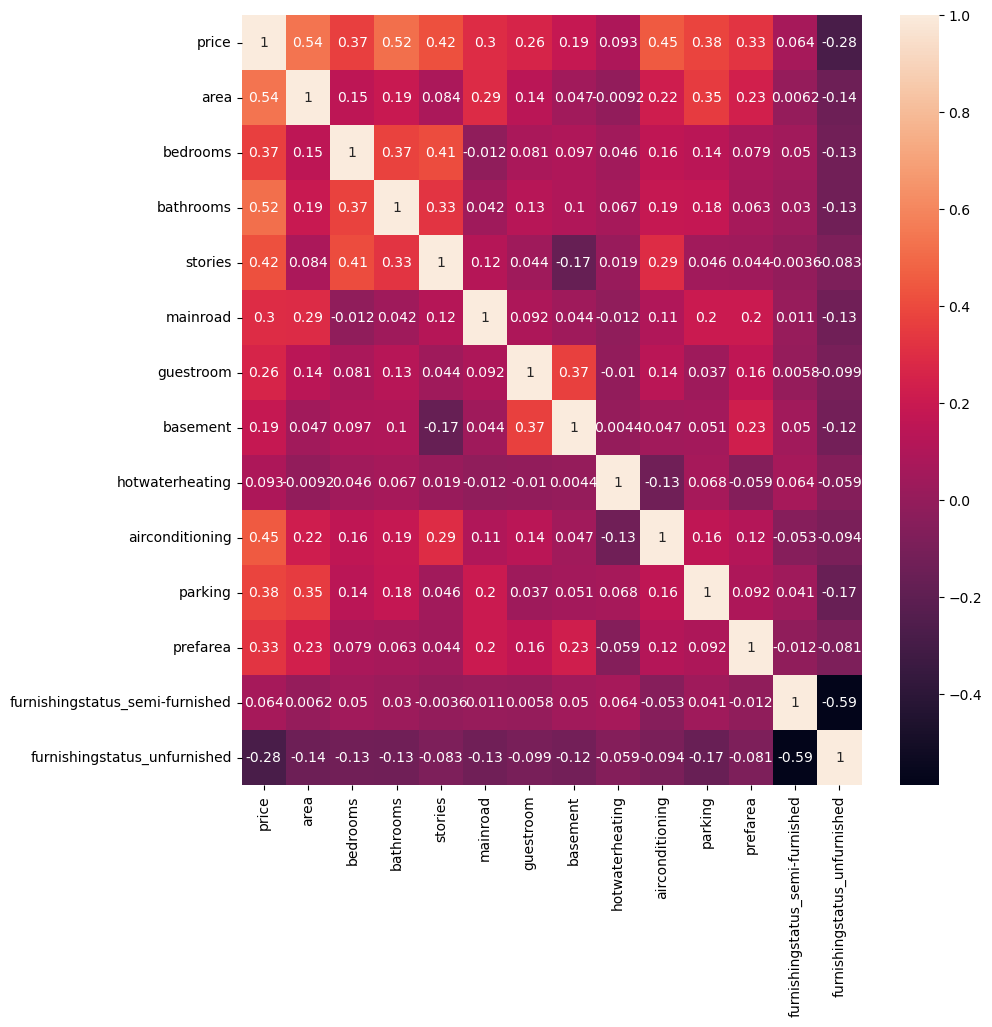

In [20]:
#Exploration

plt.figure(figsize = (10, 10))
sns.heatmap(data_encoded.corr(), annot = True)

In [21]:
## Ridge Regression 

Choose the Tuning Parameters (Regularization Multiplier λ) using cross-validation.
Present the Model with its Formula Clearly.
Plot Tuning Parameters versus Cross-Validation Error to visually select the best λ.
Test the Model on the Testing Dataset and report the error.

In [22]:
# Assume X_train and X_test are defined
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
## Define a range of lambda values
alpha_range = np.logspace(-6, 6, 13)

# Setup the model
ridge = Ridge()

# Setup the grid search with cross-validation
param_grid = {'alpha': alpha_range}
# Define a scoring dictionary
scoring = {'MSE': 'neg_mean_squared_error', 'MAE': 'neg_mean_absolute_error'}

# Setup GridSearchCV
ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alpha_range}, scoring=scoring, refit='MSE', cv=5, return_train_score=False)
 

# Perform the grid search on the scaled training data
ridge_cv.fit(X_train_scaled, y_train)

# Get the best lambda value
best_lambda = ridge_cv.best_params_['alpha']
print("Best λ: {:.6f}".format(best_lambda))

Best λ: 100.000000



## Ridge Regression Formula

The formula for Ridge Regression is:

$$
y = X\beta + \epsilon
$$

where $\beta$ is shrunk towards zero by adding a penalty equal to

$$
\alpha \sum_{i=1}^{p} \beta_i^2
$$

to the loss function. This penalty term, controlled by $\alpha$, regulates the magnitude of the coefficient vector $\beta$ to prevent overfitting.


Plotting the $\lambda$ vs Cross Validation

In [24]:
# Use the best alpha value found
ridge_best = Ridge(alpha=best_lambda)
ridge_best.fit(X_train_scaled, y_train)

# Evaluate on the test set
from sklearn.metrics import mean_squared_error

y_pred = ridge_best.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
print("Best λ: {:.6f}".format(ridge_cv.best_params_['alpha']))
print("Test MSE: {:.4f}".format(test_mse))
print("Test MAE: {:.4f}".format(test_mae))

Best λ: 100.000000
Test MSE: 1155922245729.7917
Test MAE: 868120.7116


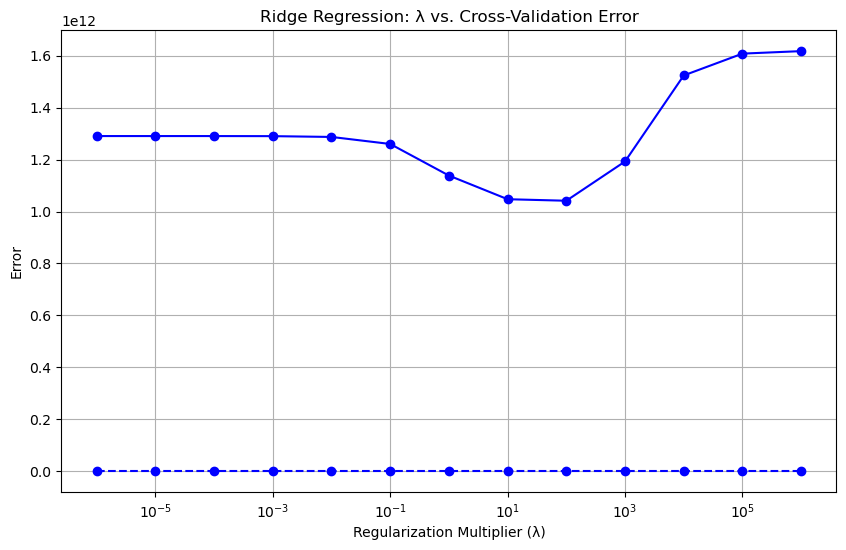

array([839469.05366197, 839468.0633756 , 839458.15550161, 839359.18984519,
       838380.72408176, 829564.2151836 , 788494.77314618, 748116.21755194,
       742945.00843568, 801569.63855229, 923286.23000176, 949669.57581794,
       952587.89694479])

In [25]:
import matplotlib.pyplot as plt

# Extract mean test scores (negative MSE) and convert them to positive MSE
mean_test_scores_mse = -ridge_cv.cv_results_['mean_test_MSE']
mean_test_scores_mae = -ridge_cv.cv_results_['mean_test_MAE']
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_range, mean_test_scores_mse, marker='o', linestyle='-', color='b',label ='MSE') 
plt.semilogx(alpha_range, mean_test_scores_mae, marker='o', linestyle='--', color='b', label='MAE')
plt.xlabel('Regularization Multiplier (λ)')
plt.ylabel('Error')
plt.title('Ridge Regression: λ vs. Cross-Validation Error')
plt.grid(True)
plt.show()
mean_test_scores_mse
mean_test_scores_mae


### Interpretation and Analysis:
**Error Metrics:**

- The error is measured in two ways: Mean Squared Error (MSE) and Mean Absolute Error (MAE). MSE is sensitive to outliers as it squares the errors before averaging, while MAE provides a more robust error metric by averaging the absolute differences.

**Optimal λ Value:**

- The optimal λ value, based on this cross-validation, is 100. This value minimizes the cross-validation error, suggesting that it provides the best balance between bias and variance in the model when generalizing to new data.

**Test Errors:**

- **Test MSE:**
  - The Test MSE at the optimal λ is approximately 1.155922245729 trillion. This high value could indicate that the model's predictions are quite spread out from the actual values or that there are outliers that significantly affect the error.

- **Test MAE:**
  - The Test MAE is approximately 868,121. This indicates that, on average, the model’s predictions are about 868,121 units away from the actual test data values.

### Analysis:
**Behavior of the Curve:**

- Initially, as λ increases from 10^-5, there is a steep decrease in the error, leveling off around λ=10^-2, indicating that a small amount of regularization improves the model significantly.

**Underfitting vs. Overfitting:**

- For very low values of λ (approaching zero), the model might be overfitting the training data, leading to higher errors on validation. As λ increases, regularization helps reduce overfitting. However, beyond the optimal λ of 100, the error starts increasing again, suggesting the model begins to underfit the data.

### Interpretation of λ: 

- λ is a penalty term that discourages large coefficients in the regression model. A λ of 100 strikes a balance in this case by penalizing complex models without overly simplifying them.

### Conclusions:
- The Ridge Regression model with λ set at 100 seems to offer the best compromise between fitting the training data and maintaining the model's ability to generalize to unseen data.
- The large scale of the MSE suggests that there might be large or several outliers in the prediction errors, or the model could still be improved, possibly by feature selection, transformation, or considering non-linear models if the relationship between the predictors and response is not adequately captured by the current linear model.
- Despite the high MSE, the relative consistency of the cross-validation error across a range of λ values indicates a certain level of robustness in the model against variance.
- The provided Test MAE and Test MSE are specific to the dataset and the context of the problem must be considered to determine if these errors are acceptable. For example, in a real estate market, a deviation of about 868,121 might be considered high depending on the scale of house prices.
- In summary, the chosen λ at 100 appears to be the most suitable for regularization in this context, striking a balance between bias and variance, yet the error metrics suggest there could be room for further improvement in the model's performance.
rmance.








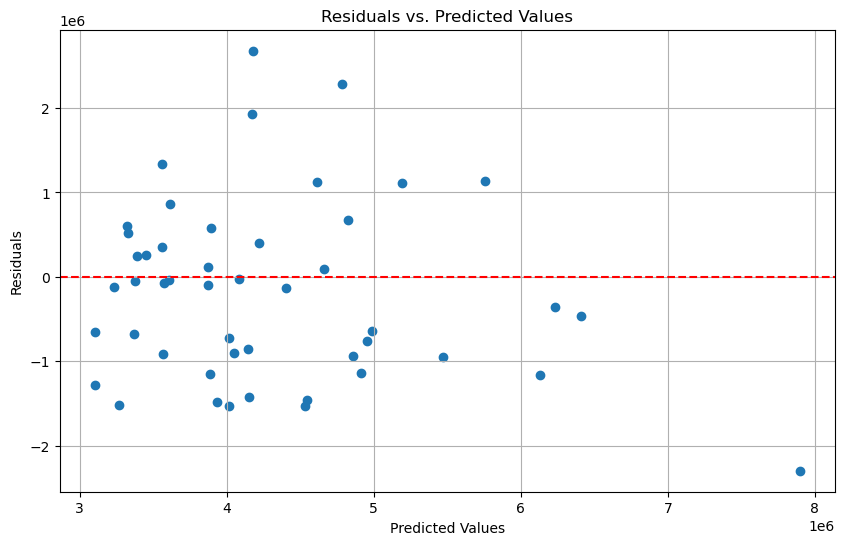

In [26]:
 

# Predictions on the test set
y_pred = ridge_best.predict(X_test_scaled)

# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()


- The LASSO (Least Absolute Shrinkage and Selection Operator) regression is a form of linear regression that adds a regularization term to the cost function. This term penalizes large coefficients and encourages sparsity (i.e., some coefficients become exactly zero).

- The basic formula for LASSO regression is:
  
    Minimize { (1/2n) || y - Xβ ||_2^2 + α || β ||_1 } 
                   
where 
   
    `y` is the response vector,
    `X` is the matrix of predictors, 
    `β` is the coefficient vector,
    `α` is the regularization parameter (lambda, λ),and 
    `|| β ||_1` is the L1-norm of the coefficient vector.


In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.544e+12, tolerance: 2.321e+10
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.544e+12, tolerance: 2.321e+10
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Best LASSO λ: 100000.000000
Test MSE for LASSO: 1220776914001.2556
Test MAE for LASSO: 888795.1056


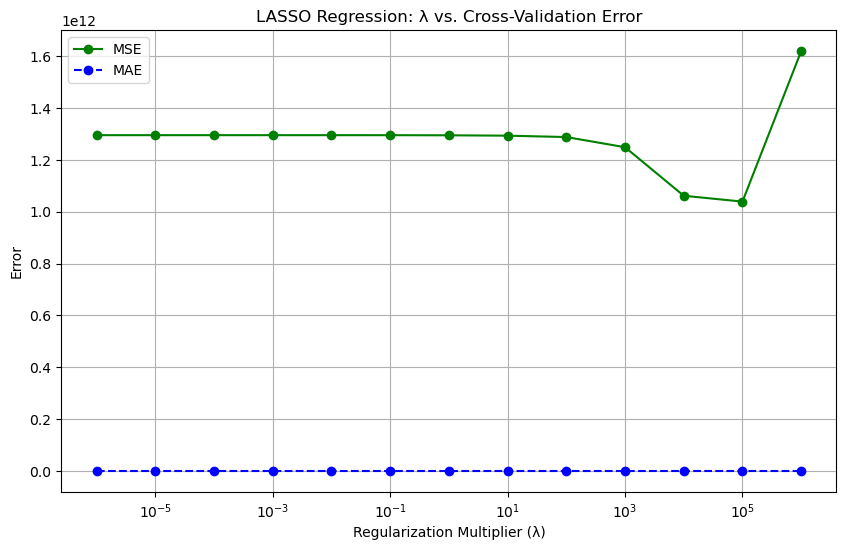

In [28]:
# Define a range of alpha values for LASSO
lasso_alpha_range = np.logspace(-6, 6, 13)  # Adjusted range


# Setup LASSO model
lasso = Lasso(max_iter=10000, random_state=42)

# Setup the grid search with cross-validation for LASSO
lasso_param_grid = {'alpha': lasso_alpha_range}
lasso_cv = GridSearchCV(lasso, lasso_param_grid, cv=5, scoring={
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}, refit='MSE')

# Perform the grid search on the scaled training data
lasso_cv.fit(X_train_scaled, y_train)

# Get the best alpha value and print it
best_lasso_alpha = lasso_cv.best_params_['alpha']
print("Best LASSO λ: {:.6f}".format(best_lasso_alpha))

# Use the best alpha value found for LASSO
lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=42)
lasso_best.fit(X_train_scaled, y_train)

# Evaluate LASSO on the test set
y_pred_lasso = lasso_best.predict(X_test_scaled)
test_mse_lasso = mean_squared_error(y_test, y_pred_lasso)
test_mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print("Test MSE for LASSO: {:.4f}".format(test_mse_lasso))
print("Test MAE for LASSO: {:.4f}".format(test_mae_lasso))

# Plot LASSO alpha vs. MSE
mean_test_scores_mse = -lasso_cv.cv_results_['mean_test_MSE']
mean_test_scores_mae = -lasso_cv.cv_results_['mean_test_MAE']
plt.figure(figsize=(10, 6))
plt.semilogx(lasso_alpha_range, mean_test_scores_mse, marker='o', linestyle='-', color='g',label='MSE')
plt.semilogx(lasso_alpha_range, mean_test_scores_mae, marker='o', linestyle='--', color='b', label='MAE')
plt.xlabel('Regularization Multiplier (λ)')
plt.ylabel('Error')
plt.title('LASSO Regression: λ vs. Cross-Validation Error')
plt.legend()
plt.grid(True)
plt.show()

## Result Interpretation:

### Optimal λ for LASSO:
- The best λ value found is 100,000. This is on the higher end of the regularization spectrum, suggesting a model that strongly penalizes the magnitude of the coefficients to prevent overfitting.

### Error Analysis:
- **Test MSE**: The Test MSE at the best λ is approximately 1.220776914001 trillion. This large error indicates that the model's predictions are, on average, far from the actual values. High MSE often points to the presence of outliers or a model that does not capture the complexity of the data well.
- **Test MAE**: The Test MAE is around 888,795. This value is more robust to outliers compared to MSE and suggests that, on average, the model predictions are approximately this value away from the true prices.

### Plot Observations:
- The MSE remains relatively stable across various λ values, with a slight upward trend starting at λ=10.
- The MAE remains consistently low across all λ values, which is typical since it is less sensitive to outliers.
- At very high λ values (10^5), both MSE and MAE spike, indicating a model that is too simplistic and unable to capture the data's underlying pattern (underfitting).

## Recommendations:

### Model Complexity:
- Since the optimal λ is very high, the LASSO regression is potentially oversimplifying the model. It might be useful to check if the data has features that do not contribute to predicting the target variable and could be removed without such strong regularization.

### Feature Review:
- Examine the features that LASSO has selected and determine if they make sense from a domain perspective. The LASSO model may have shrunk the coefficients of less important predictors to zero.

### Outlier Analysis:
- Investigate the data for outliers or leverage points that could disproportionately influence the model, given the high MSE.

### Model Comparison:
- Compare LASSO with other models, such as Ridge regression or Elastic Net, which combines LASSO and Ridge, to see if they offer better performance.

### Error Metrics Context:
- Consider the distribution of the house prices. If the dataset contains very expensive properties, an average error of around 888,795 may not be unreasonable.

### Alternative Approaches:
- Since the LASSO regression might be too simple for the data complexity, it might be beneficial to explore more complex models, including non-linear ones if there is reason to believe that the relationship between the predictors and the target is non-linear.

### Model Diagnostics:
- Perform a residual analysis to check for non-random patterns that indicate a poor fit and to validate model assumptions.

### Cross-Validation Strategy:
- If not already done, use a more robust cross-validation strategy, like K-fold or Leave-One-Out, to ensure that the error estimates are reliable.

### Data Transformation:
- Consider transforming some features or target variable if they do not have a linear relationship or are heavily skewed.

In summary, the current LASSO model with λ set at 100,000 suggests that there is either a simplification of the model or an i
ndication of data issues such as outliers. Further inv are recommended to improve the prediction accuracy.mended to improve the prediction accuracy.
ambda

### Nadaraya -Watson Estimator 

The **Nadaraya-Watson estimator** is a type of kernel regression used in statistics for non-parametric smoothing. It's particularly useful for estimating a conditional expectation of a response variable given a set of predictor variables in cases where the relationship might be highly non-linear.

The formula for the Nadaraya-Watson estimator is:
$$
\hat{f}(x) = \frac{\sum_{i=1}^n K_h(x - X_i) Y_i}{\sum_{i=1}^n K_h(x - X_i)}
$$

Where:
- <b>$$\hat{f}(x)$$</b>is the estimated value of the dependent variable at point \(x\).
- <b>\( n \)</b> is the number of data points.
- <b>\( X_i \)</b> and <b>\( Y_i \)</b> are the observed values of the predictor and response variables, respectively.
- <b>\( K_h(x - X_i) \)</b> is the kernel function, which weights the influence of each data point <b>\( X_i \)</b> on the estimation at <b>\( x \)</b>. The kernel function is often Gaussian, but other types like Epanechnikov or Uniform can also be used.
- <b>\( h \)</b> is the bandwidth parameter that controls the width of the kernel. It plays a crucial role in smoothing, where a smaller <b>\( h \)</b> results in less smoothing (more variance and less bias), and a larger <b>\( h \)</b> results in more smoothing (more bias and less variance).

The choice of kernel and the bandwidth parameter can significantly affect the estimator's performance, and methods like cross-validation are typically used to select an optimal bandwidth.




In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# Nadaraya-Watson kernel regression function with Gaussian kernel
def nw_kernel_regression(x, X, y, bandwidth, lambda_reg):
    weights = np.exp(-0.5 * ((X - x) / bandwidth) ** 2) / (np.sqrt(2 * np.pi) * bandwidth)
    weights /= np.sum(weights)  # Normalize weights
    regularization = lambda_reg * np.sum(weights ** 2)
    return np.dot(weights, y) / (1 + regularization)






In [31]:
# Prepare the data
data_train, data_test = train_test_split(data_filtered, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
data_train['bedrooms_scaled'] = scaler.fit_transform(data_train[['bedrooms']])
data_test['bedrooms_scaled'] = scaler.transform(data_test[['bedrooms']])

# Cross-validation to find the best bandwidth and lambda
kf = KFold(n_splits=5)
bandwidths = np.linspace(0.1, 2, 20)
lambdas = np.linspace(0.001, 0.1, 20)
errors = np.zeros((len(bandwidths), len(lambdas)))
mae_errors = np.zeros((len(bandwidths), len(lambdas)))

for i, bandwidth in enumerate(bandwidths):
    for j, lambda_reg in enumerate(lambdas):
        fold_errors = []
        fold_mae = []
        for train_index, test_index in kf.split(data_train):
            X_train, X_test = data_train['bedrooms_scaled'].iloc[train_index], data_train['bedrooms_scaled'].iloc[test_index]
            y_train, y_test = data_train['price'].iloc[train_index], data_train['price'].iloc[test_index]
            predictions = [nw_kernel_regression(x, X_train, y_train, bandwidth, lambda_reg) for x in X_test]
            fold_errors.append(np.mean((predictions - y_test) ** 2))
            fold_mae.append(np.mean(np.abs(predictions - y_test)))
        errors[i, j] = np.mean(fold_errors)
        mae_errors[i, j] = np.mean(fold_mae)

opt_idx = np.unravel_index(np.argmin(errors), errors.shape)
opt_bandwidth = bandwidths[opt_idx[0]]
opt_lambda = lambdas[opt_idx[1]]

# Test the model on the testing dataset
X_test = data_test['bedrooms_scaled']
y_test = data_test['price']
predictions_test = [nw_kernel_regression(x, data_train['bedrooms_scaled'], data_train['price'], opt_bandwidth, opt_lambda) for x in X_test]
test_error = np.mean((predictions_test - y_test) ** 2)
test_mae = np.mean(np.abs(predictions_test - y_test))

# Output results
print("Optimal bandwidth:", opt_bandwidth)
print("Optimal lambda:", opt_lambda)
print("Test MSE:", test_error)
print("Test MAE:", test_mae)

Optimal bandwidth: 0.7
Optimal lambda: 0.1
Test MSE: 1466979205138.1472
Test MAE: 946699.882505023


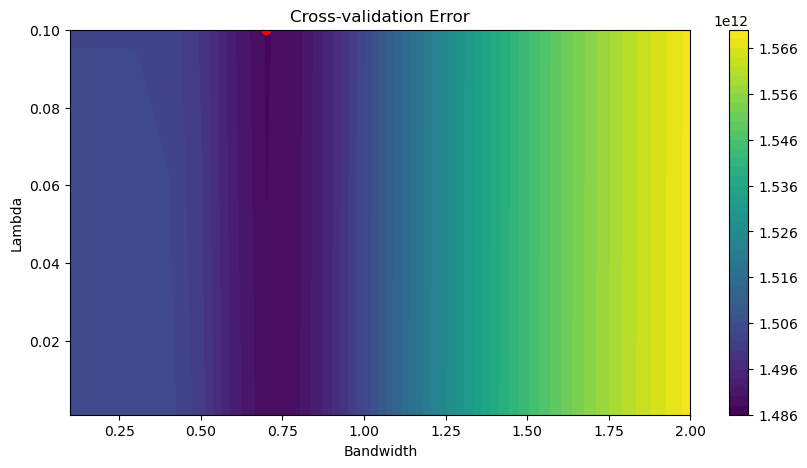

In [32]:


# Plotting error contours for visualization
plt.figure(figsize=(10, 5))
plt.contourf(bandwidths, lambdas, errors.T, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Cross-validation Error')
plt.xlabel('Bandwidth')
plt.ylabel('Lambda')
plt.scatter([opt_bandwidth], [opt_lambda], color='red')  # Optimal parameters
plt.show()

## Result Interpretation:

### Optimal Hyperparameters:
- **Optimal Bandwidth**: The best-performing bandwidth is 0.7. This suggests that, for the given data, a kernel width of 0.7 strikes the best balance between bias and variance, capturing the underlying pattern without fitting the noise in the data.
- **Optimal Lambda**: The optimal λ is 0.1, indicating a mild level of regularization that helps to prevent overfitting while still allowing for a flexible fit to the data.

### Test Errors:
- **Test MSE**: The Test MSE with the optimal hyperparameters is approximately 1.466979205138 trillion. The magnitude of this error suggests that the model may still be missing some complexity or patterns in the data, or there could be outliers influencing the error significantly.
- **Test MAE**: The Test MAE is approximately 946,700. This error metric implies that the model's average prediction is about 946,700 units off from the actual values. Given the robustness of MAE to outliers, this model may perform relatively better in the presence of outliers compared to others with higher sensitivity to these points.

### Heat Map Observations:
- The color gradient indicates that lower values of both λ and bandwidth generally correspond to lower cross-validation errors.
- The optimal points (marked with a red dot) do not lie at the extremes, suggesting a balanced model in terms of complexity and regularization.

## Recommendations:

- **Model Complexity**: Refine the model's complexity through non-linear feature transformations or by adding polynomial terms.
- **Outlier Influence**: Assess and mitigate the impact of outliers using robust regression methods and residual analysis.
- **Error Contextualization**: Contextualize the error metrics within the data's scale; a high MAE might be acceptable for expensive properties.
- **Diagnostic Analysis**: Conduct residual diagnostics to uncover potential model deficiencies.
- **Model Benchmarking**: Compare the model's performance with alternative regression techniques to ensure optimal selection.
- **Cross-Validation Methodology**: Implement a robust cross-validation approach to validate model performance.
- **Feature Engineering**: Explore the creation or transformation of features to improve model fit.
- **Hyperparameter Refinement**: Conduct further hyperparameter optimization around the identified optimal settings.
- **Data Normalization**: Normalize the data to address scale sensitivity inherent in kernel methods.
